The question that I try to answer here, is to find a simple model to predict truck travelled distance between two locations based on the shortest distance between them. The data that we have is a csv file of the location of plants, a csv file of customer's location. A csv file of historic travels between plants and customers. We want to predict the distance for those pairs we do not have data for.


## Import libraries

In [32]:
import pandas as pd
import numpy as np

from geopy.distance import distance

## Import data files

In [33]:
plants = pd.read_csv('plants.csv')
plants.head()

,plant_number,latitude,longitude
0,plant_1,33.415172,-86.230904
1,plant_2,35.275113,-92.471814
2,plant_3,41.225687,-81.416651
3,plant_4,34.707729,-91.674426
4,plant_5,34.088075,-89.644492


In [34]:
customers = pd.read_csv('customers.csv')
customers.head()

,customer_number,latitude,longitude
0,customer_1,33.277181,-97.982051
1,customer_2,45.075334,-87.906426
2,customer_3,33.837430,-95.934696
3,customer_4,33.362368,-86.999961
4,customer_5,42.997963,-84.409003


In [35]:
df = pd.read_csv('historicdata.csv')
df.head()

,plant,customer,distance1,distance2,distance3
0,plant_1,customer_1,1022.538892,1909.071326,1804.490045
1,plant_1,customer_4,79.792130,113.169995,122.108886
2,plant_1,customer_5,1078.192940,1722.460238,2546.346183
3,plant_1,customer_9,437.484709,718.872605,952.808488
4,plant_1,customer_10,970.980839,2023.114377,2563.629101


## Data cleaning

Let's find average of historic milages and add the location of plants and customers

In [36]:
df['distance_mean'] = df[['distance1', 'distance2', 'distance3']].mean(axis=1)

In [37]:
df = df.merge(plants, left_on='plant', right_on='plant_number')
df.rename(columns={'latitude':'plant_lat',
          'longitude':'plant_long'}, inplace=True)

In [38]:
df = df.merge(customers, left_on='customer', right_on='customer_number')
df.rename(columns={'latitude':'customer_lat',
          'longitude':'customer_long'}, inplace=True)

In [39]:
df.head()

,plant,customer,distance1,distance2,distance3,distance_mean,plant_number,plant_lat,plant_long,customer_number,customer_lat,customer_long
0,plant_1,customer_1,1022.538892,1909.071326,1804.490045,1578.700088,plant_1,33.415172,-86.230904,customer_1,33.277181,-97.982051
1,plant_2,customer_1,521.146509,1011.695183,1165.806764,899.549485,plant_2,35.275113,-92.471814,customer_1,33.277181,-97.982051
2,plant_4,customer_1,493.593647,1006.659772,1283.408347,927.887255,plant_4,34.707729,-91.674426,customer_1,33.277181,-97.982051
3,plant_7,customer_1,752.197911,1265.738917,1303.771773,1107.236200,plant_7,36.162604,-90.194118,customer_1,33.277181,-97.982051
4,plant_9,customer_1,1517.126747,2955.654637,3138.197330,2536.992905,plant_9,38.947328,-78.431934,customer_1,33.277181,-97.982051


In [40]:
df.drop(columns=['customer_number', 'plant_number'], inplace=True)

Lets find the shortest distance between points by using distance from geopy

In [41]:
## Lets find geodesc distance
df['geo_distance'] = np.nan
for index, row in df.iterrows():
    
    point1 = [row['plant_lat'], row['plant_long']]
    point2 = [row['customer_lat'], row['customer_long']]
    df.loc[index,'geo_distance'] = distance(point1, point2).miles

In [42]:
df.head(4)

,plant,customer,distance1,distance2,distance3,distance_mean,plant_lat,plant_long,customer_lat,customer_long,geo_distance
0,plant_1,customer_1,1022.538892,1909.071326,1804.490045,1578.700088,33.415172,-86.230904,33.277181,-97.982051,679.406911
1,plant_2,customer_1,521.146509,1011.695183,1165.806764,899.549485,35.275113,-92.471814,33.277181,-97.982051,343.981693
2,plant_4,customer_1,493.593647,1006.659772,1283.408347,927.887255,34.707729,-91.674426,33.277181,-97.982051,375.229400
3,plant_7,customer_1,752.197911,1265.738917,1303.771773,1107.236200,36.162604,-90.194118,33.277181,-97.982051,485.635360


In [43]:
import seaborn as sns

<AxesSubplot:xlabel='distance_mean', ylabel='geo_distance'>

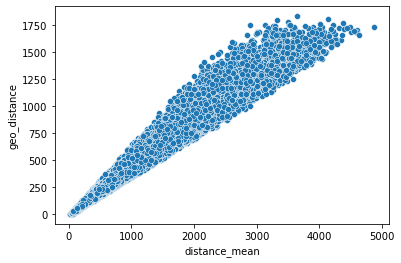

In [44]:
sns.scatterplot(x=df['distance_mean'], y=df['geo_distance'])

## Model training

We split the data into two sets, training and test. Then use cross-validation with 5 fold to do a regression. we then find R2 and mean MAE

In [98]:
X = df['geo_distance'].values.reshape(-1, 1)
y = df['distance_mean'].values.reshape(-1, 1)

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, cross_val_predict

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [101]:
model = LinearRegression()
kfold = KFold(n_splits=5, shuffle = False)

cv_results = cross_validate(model, X_train, y_train, cv = kfold, scoring='neg_mean_squared_error')
cv_scores = cv_results['test_score']
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

[-31837.07148821 -31509.91000364 -30701.8764297  -29159.01551928
 -33288.62965701]
-31299.300619566267 1358.581599475115


In [102]:
final_model = model.fit (X_train, y_train)

In [103]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

train_r2 = round(r2_score(y_train, y_train_pred), 2)
test_r2 = round(r2_score(y_test, y_test_pred), 2)
print('train R2:', train_r2)
print('test R2: ', test_r2)

train R2: 0.95
test R2:  0.95


The R2 for test and train are very similar. The model is not overfitting. Let's use it to predict the distance between plants and customers. But first lets see what pair we don't have data for.

In [104]:
df['plant_customer'] = [str(x) + '**' + str(y) for x, y in zip(df['plant'], df['customer'])]

In [105]:
all_pair = []
for plant_name in plants['plant_number'].unique():
    for customer in customers['customer_number']:
        pair = plant_name + '**' + customer
        all_pair.append(pair)

In [106]:
len(all_pair)

100000

In [108]:
unavailable_pairs = list(set(all_pair) - set(all_pair).intersection(set(df['plant_customer'])))

In [109]:
len(unavailable_pairs)

72555

In [110]:
unavailable = pd.DataFrame()

In [111]:
unavailable['plant_number'] = [pair.split('**')[0] for pair in unavailable_pairs]
unavailable['customer_number'] = [pair.split('**')[1] for pair in unavailable_pairs]
unavailable.head()

,plant_number,customer_number
0,plant_6,customer_1439
1,plant_10,customer_2229
2,plant_13,customer_3429
3,plant_14,customer_1392
4,plant_14,customer_2576


In [112]:
unavailable = unavailable.merge(plants, on='plant_number', how='left')
unavailable.rename(columns={'latitude':'plant_lat',
          'longitude':'plant_long'}, inplace=True)
unavailable = unavailable.merge(customers, on='customer_number', how='left')
unavailable.rename(columns={'latitude':'customer_lat',
          'longitude':'customer_long'}, inplace=True)

In [113]:
unavailable.head()

,plant_number,customer_number,plant_lat,plant_long,customer_lat,customer_long
0,plant_6,customer_1439,33.184965,-108.283899,32.704849,-87.909003
1,plant_10,customer_2229,33.692519,-94.508827,36.265853,-90.353542
2,plant_13,customer_3429,34.698649,-93.802288,37.671933,-82.035654
3,plant_14,customer_1392,34.542425,-85.739381,33.647213,-88.087360
4,plant_14,customer_2576,34.542425,-85.739381,34.801664,-96.070249


In [114]:

unavailable['geo_distance'] = np.nan
for index, row in unavailable.iterrows():
    
    point1 = [row['plant_lat'], row['plant_long']]
    point2 = [row['customer_lat'], row['customer_long']]
    unavailable.loc[index,'geo_distance'] = distance(point1, point2).miles

In [115]:
X = unavailable['geo_distance'].values.reshape(-1,1)
 

In [116]:
prediction = final_model.predict(X)

In [117]:
unavailable['distance'] = prediction

In [118]:
unavailable.head()

,plant_number,customer_number,plant_lat,plant_long,customer_lat,customer_long,geo_distance,distance
0,plant_6,customer_1439,33.184965,-108.283899,32.704849,-87.909003,1182.481804,2619.567815
1,plant_10,customer_2229,33.692519,-94.508827,36.265853,-90.353542,294.994133,673.189326
2,plant_13,customer_3429,34.698649,-93.802288,37.671933,-82.035654,688.322231,1535.810153
3,plant_14,customer_1392,34.542425,-85.739381,33.647213,-88.087360,148.096215,351.022656
4,plant_14,customer_2576,34.542425,-85.739381,34.801664,-96.070249,588.346692,1316.550499


In [119]:
for_submit = unavailable[['plant_number', 'customer_number', 'distance']]

In [120]:
for_submit.to_excel('report.xlsx', index=False)